In [1]:
from math import exp, sqrt, cos
import itertools

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

## Konstante i osnovne funkcije

In [2]:
kb = 8.6173303 * 10**(-5)
pi = np.pi

hbar_w_op = 0.2
hbar_w_ac = 0.03
G_op2 = 0.25
G_ac2 = 0.05
eta = 5 * 10**(-3) # min=0.3 meV
t = 2.52
Ef = 0.5
KF = Ef / 3 * 2 / t

In [3]:
def fermi_dirac(E, Ef, T): 
    if T > 0:
       if E > Ef:
           return exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1)
       else:
           return 1 / (exp((E - Ef) / (kb * T)) + 1)
    else:
        if E < Ef: 
            return 0 
        else: 
            return 1

def bose_einstein(E,T): 
    assert T > 0
    return exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1)

def chemical_potential(T):
    return Ef - pi**2 / 6 / Ef * (kb * T)**2

def eps(K):
    return 3 * t / 2 * K

## Optički fononi


In [4]:
def ss_sum_part(K, hbar_w, hbar_w_ph, T, u):
    def summand(s1, s2):
        return ((bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)) / (hbar_w + s1 * eps(KF) - s1 * eps(K) + s2 * hbar_w_ph + eta * 1j))
    sum = 0
    for s1, s2 in itertools.product([-1,1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K

def ss_sum_real(K, hbar_w, hbar_w_ph, T, u):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u).real

def ss_sum_imag(K, hbar_w, hbar_w_ph, T, u):
    return ss_sum_part(K, hbar_w, hbar_w_ph, T, u).imag

def mem_fn(ss_sum_fn, hbar_w, hbar_w_ph, u=Ef, T=50):    
    integral_k = integrate.quad(ss_sum_fn, 0, KF*8, args=(hbar_w, hbar_w_ph, T, u), limit=80000)[0]
    return -G_op2 * integral_k / (2*pi) * 2


**Memorijska funkcija**

<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_12984\1476856509.py:22: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.20, 0.002 , f"$\eta = $ {eta:.4f} $eV$" , fontsize =10)


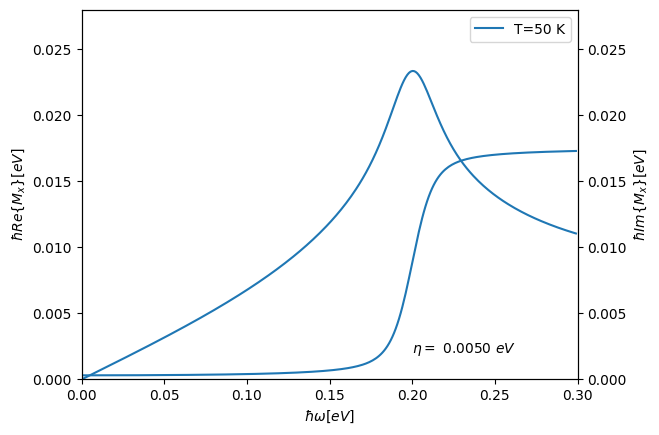

In [5]:
result_real = []
result_imag = []
ws = np.arange(0, 0.3, 0.001)
T=50
for w in ws:
    result_real.append(mem_fn(ss_sum_real, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T)))
    result_imag.append(mem_fn(ss_sum_imag, hbar_w=w, hbar_w_ph=hbar_w_op, u=chemical_potential(T)))

fig, ax1 = plt.subplots()
ax1.plot(ws, result_real, label=f"T={T} K")
ax1.set_xlabel(r"$\hbar \omega [eV]$" )
ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$" )
ax1.set_xlim([0.0, 0.3])
ax1.set_ylim([0.0, 0.028])

ax2 = ax1.twinx()
ax2.plot(ws, result_imag, label=f"T={T} K")
ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
ax2.set_xlim([0.0, 0.3])
ax2.set_ylim([0.0, 0.028])

plt.text(0.20, 0.002 , f"$\eta = $ {eta:.4f} $eV$" , fontsize =10)

plt.legend()
plt.show()

Podintegralna funkcija za memorijsku funkciju

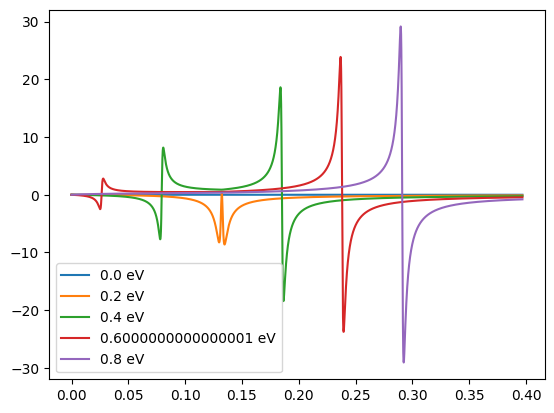

In [6]:
ws = np.arange(0, 1, 0.2)
T=50
ks = np.arange(0, KF*3, 0.00001)
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_real(k, w, hbar_w_op, T, chemical_potential(T))
        ss_sums.append(ss)
    plt.plot(ks, ss_sums, label = f"{w} eV")
plt.legend()

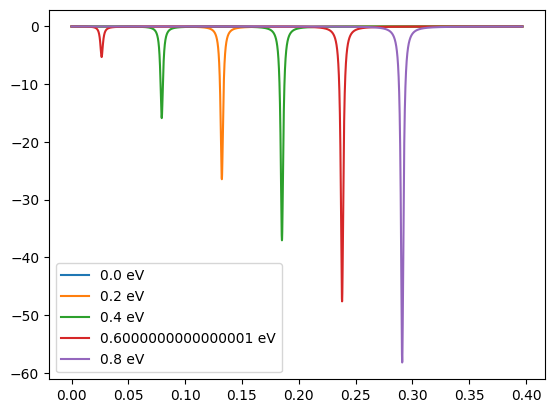

In [7]:
ws = np.arange(0, 1, 0.2)
T=50
ks = np.arange(0, KF*3, 0.00001)
for w in ws:
    ss_sums = []
    for k in ks:
        ss = ss_sum_imag(k, w, hbar_w_op, T, chemical_potential(T))
        ss_sums.append(ss)
    plt.plot(ks, ss_sums, label = f"{w} eV")
plt.legend()

## Akustični fononi

In [8]:
def ss_sum_ac_part_2(K, phi, hbar_w, hbar_w_ph, T, u): # K' točka
    def summand(s1, s2, K_delta, phi_delta):
        abs_K = sqrt(K**2 + K_delta**2 - 2 * K_delta * K * cos(phi_delta - phi))
        return (bose_einstein(hbar_w_ph * abs_K, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)) / (hbar_w + s1 * eps(KF) - s1 * eps(K) + s2 * hbar_w_ph * abs_K + eta * 1j) * K * abs_K**2 * (1 - cos(phi))
    sum = 0
    K_phi_deltas = [(4 / 3 / sqrt(3) * pi, pi / 2), (4 / 3 / sqrt(3) * pi, pi / 2 + pi /3), (4 / 3 / sqrt(3) * pi, pi / 2 + 2 / 3 * pi), (4 / 3 / sqrt(3) * pi, pi / 2 + pi), (4 / 3 / sqrt(3) * pi, pi / 2 + 4 / 3 * pi), (4 / 3 / sqrt(3) * pi, pi / 6)]
    for K_d, phi_d in K_phi_deltas:
        for s1, s2 in itertools.product([-1,1], [-1, 1]):
            sum = sum + summand(s1, s2, K_d, phi_d)
    return  sum

def ss_sum_ac_part_2_real(K, phi, hbar_w, hbar_w_ph, T, u):
    return ss_sum_ac_part_2(K, phi, hbar_w, hbar_w_ph, T, u).real

def ss_sum_ac_part_2_imag(K, phi, hbar_w, hbar_w_ph, T, u):
    return ss_sum_ac_part_2(K, phi, hbar_w, hbar_w_ph, T, u).imag


def mem_fn_ac(ss_sum_fn_2, hbar_w, hbar_w_ph, u=Ef, T=50):    
    integral_k_phi = integrate.nquad(ss_sum_fn_2, ([0.00, KF*7], [0, 2*pi]), args=(hbar_w, hbar_w_ph, T, u))[0]
    return -G_ac2 / (2*pi)**2 * 2 * integral_k_phi


**Memorijska funkcija**

<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_12984\1081270104.py:22: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.10, 0.001 , f"$\eta = $ {eta:.4f} $eV$" , fontsize =10)


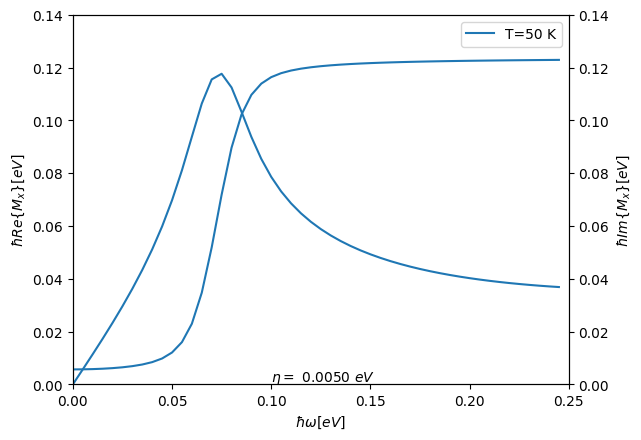

In [10]:
result_real = []
result_imag = []
ws = np.arange(0.0, 0.25, 0.005)
T=50
for w in ws:
    result_real.append(mem_fn_ac(ss_sum_ac_part_2_real, hbar_w=w, hbar_w_ph=hbar_w_ac, u=chemical_potential(T)))
    result_imag.append(mem_fn_ac(ss_sum_ac_part_2_imag, hbar_w=w, hbar_w_ph=hbar_w_ac, u=chemical_potential(T)))

fig, ax1 = plt.subplots()
ax1.plot(ws, result_real, label=f"T={T} K")
ax1.set_xlabel(r"$\hbar \omega [eV]$" )
ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$" )
ax1.set_xlim([0.0, 0.25])
ax1.set_ylim([0.0, 0.14])

ax2 = ax1.twinx()
ax2.plot(ws, result_imag, label=f"T={T} K")
ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$" )
ax2.set_xlim([0.0, 0.25])
ax2.set_ylim([0.0, 0.14])

plt.text(0.10, 0.001 , f"$\eta = $ {eta:.4f} $eV$" , fontsize =10)

plt.legend()
plt.show()